In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calibrate_camera():
    nx, ny = 9, 6
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = []
    imgpoints = []
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return img_undistorted

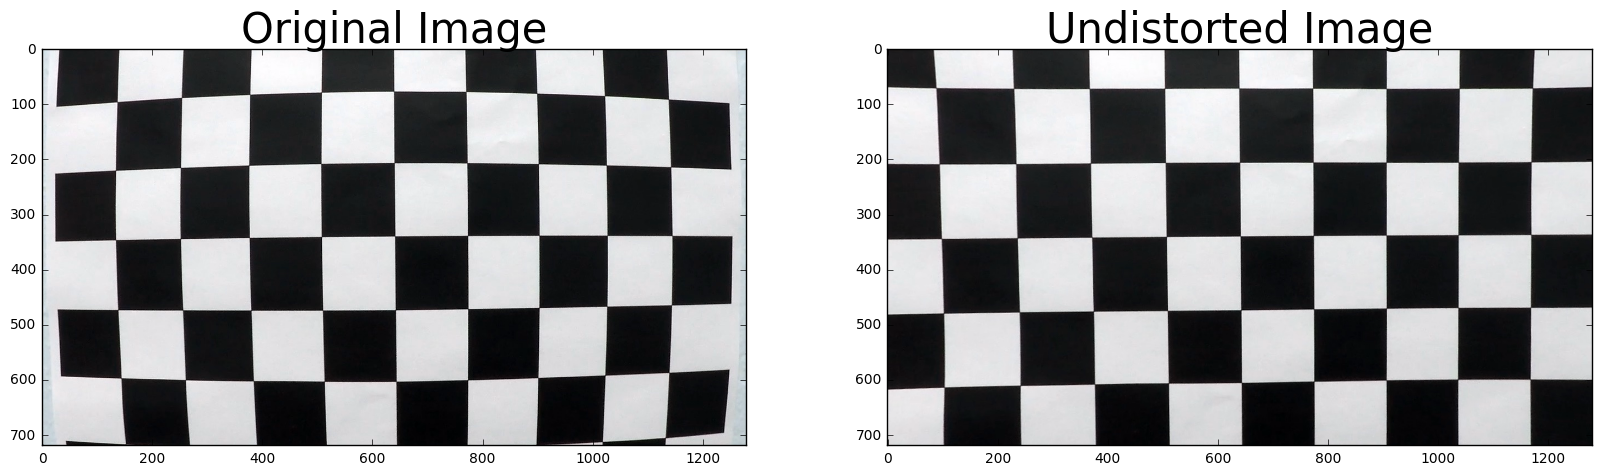

In [3]:
mtx, dist = calibrate_camera()
img = cv2.imread('camera_cal/calibration1.jpg')


img_undistorted = undistort(img, mtx, dist)

cv2.imwrite('camera_cal/calibration1_undist.jpg', img_undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

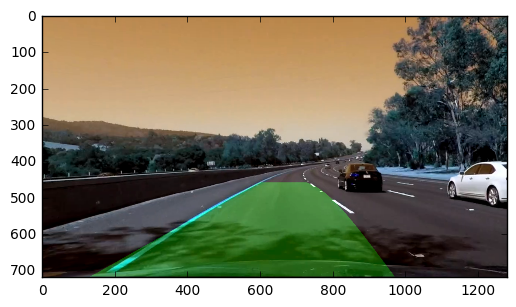

In [33]:
img_file = 'frames/frame1052.png'
test_image = cv2.imread(img_file)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)


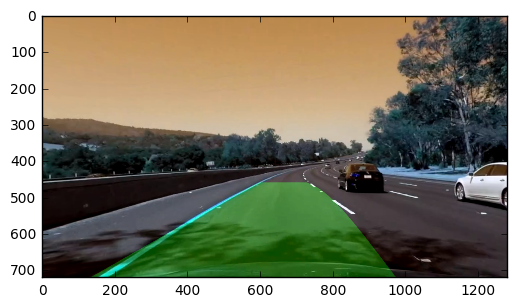

In [34]:
undist_ti = undistort(test_image, mtx, dist)
plt.imshow(undist_ti)

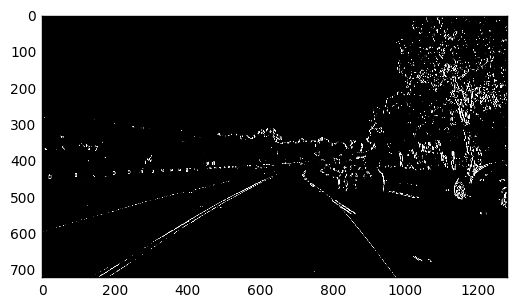

In [35]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

grad_binary_x_ti = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
plt.imshow(grad_binary_x_ti, cmap='gray')

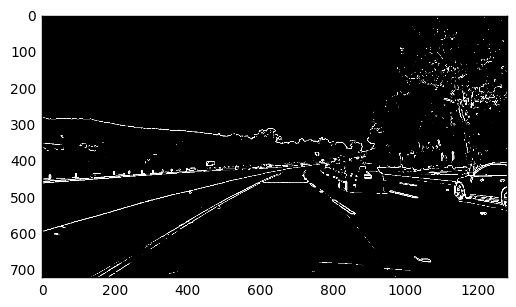

In [36]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

mag_binary_ti = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
_, mag_binary_ti = cv2.threshold(mag_binary_ti,0,255,cv2.THRESH_BINARY)
mag_binary_ti = cv2.cvtColor(mag_binary_ti, cv2.COLOR_GRAY2RGB)
plt.imshow(mag_binary_ti, cmap='gray')

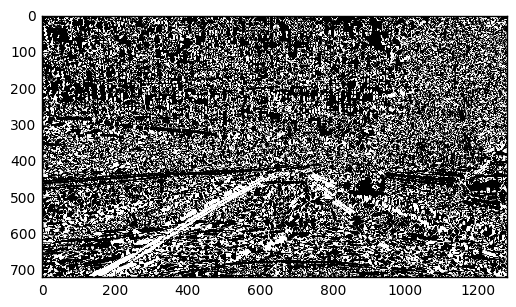

In [37]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype('uint8')

dir_binary_ti = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_binary_ti, cmap='gray')

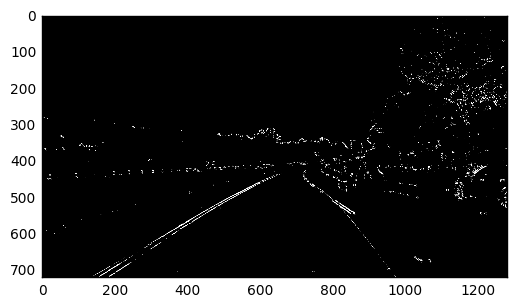

In [38]:
gradx = abs_sobel_thresh(undist_ti, orient='x', thresh_min=30, thresh_max=100)
grady = abs_sobel_thresh(undist_ti, orient='y', thresh_min=30, thresh_max=100)
mag_binary = mag_thresh(undist_ti, sobel_kernel=3, mag_thresh=(50, 200))
dir_binary = dir_threshold(undist_ti, sobel_kernel=15, thresh=(0.7, 1.2))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
plt.imshow(combined, cmap='gray')

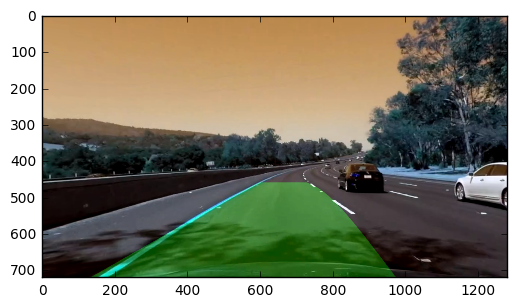

In [39]:
hard_image = cv2.imread(img_file)
hard_image = cv2.cvtColor(hard_image, cv2.COLOR_BGR2RGB)
hard_image = undistort(hard_image, mtx, dist)
plt.imshow(hard_image)

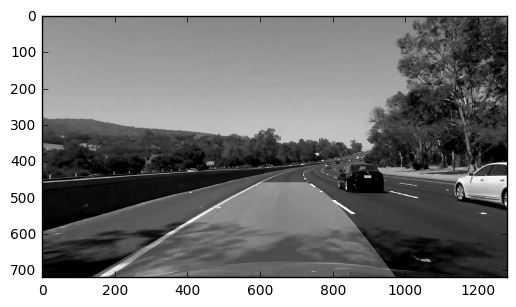

In [40]:
plt.imshow(hard_image[:,:,1], cmap='gray')

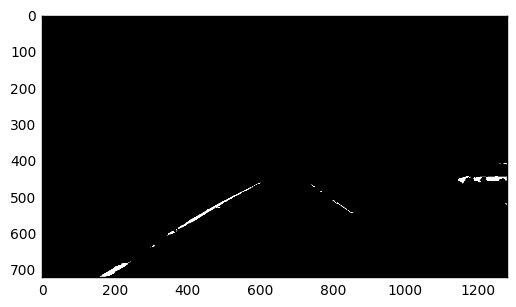

In [62]:
hard_hls = cv2.cvtColor(hard_image, cv2.COLOR_RGB2HLS)
h_channel = hard_hls[:,:,1]
s_channel = hard_hls[:,:,2]
binary_s = np.zeros_like(s_channel)
binary_s[(s_channel > 150) & (s_channel <= 255) & (h_channel > 100) & (h_channel <= 255)] = 1
plt.imshow(binary_s, cmap='gray')

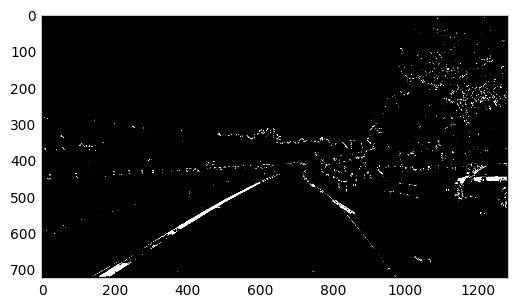

In [63]:
binary = np.zeros_like(combined)
binary[(combined == 1) | (binary_s == 1)] = 1
plt.imshow(binary, cmap='gray')

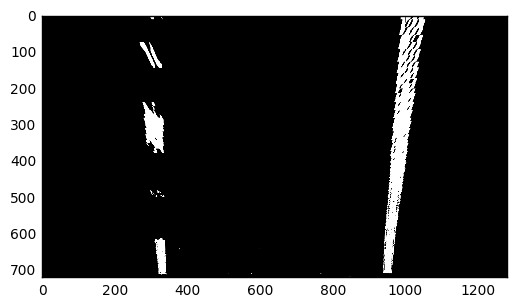

In [14]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (binary.shape[1], binary.shape[0])
binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(binary_warped, cmap='gray')

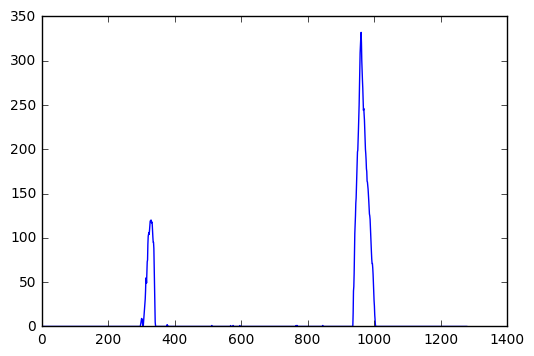

In [15]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [16]:
def sliding_fit(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit, out_img

In [17]:
left_lane_inds, right_lane_inds, left_fit, right_fit, out_img = sliding_fit(binary_warped)

def get_plot_points(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
print(left_fitx.shape)
print(ploty.shape)
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720,)
(720,)


NameError: name 'nonzeroy' is not defined

In [18]:
def easy_fit(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_lane_inds, right_lane_inds, left_fit, right_fit

In [19]:
left_lane_inds, right_lane_inds, left_fit, right_fit = easy_fit(binary_warped, left_fit, right_fit)
# Generate x and y values for plotting
left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
print(left_fitx.shape)
print(ploty.shape)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'nonzeroy' is not defined

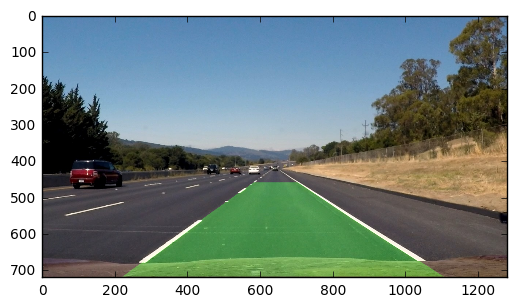

In [20]:
def draw_lane(image, binary_warped, left_fit, right_fit, m_inv):
    left_fitx, right_fitx, ploty = get_plot_points(img, left_fit, right_fit)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

drawed_lane = draw_lane(test_image, binary_warped, left_fit, right_fit, Minv)
plt.imshow(drawed_lane)

In [71]:
src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
left_lane_inds = None
right_lane_inds = None
left_fit = None
right_fit = None
left_fitx = None
right_fitx = None
ploty = None
frame = 0

def euclidean_distances(x1, x2, y1, y2):
    p1 = np.dstack((x1, y1))[0]
    p2 = np.dstack((x2, y2))[0]
    distances = np.linalg.norm(p1-p2, axis=1)
    return distances


def process_image(image):
    global left_lane_inds
    global right_lane_inds
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global ploty
    global frame
    image = undistort(image, mtx, dist)
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=30, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.2))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    hls_h = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,1]
    hls_s = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    binary_s = np.zeros_like(hls_s)
    binary_s[(hls_s > 150) & (hls_s <= 255) & (hls_h > 100) & (hls_h <= 255)] = 1
    binary = np.zeros_like(combined)
    binary[(combined == 1) | (binary_s == 1)] = 1
    img_size = (binary.shape[1], binary.shape[0])
    binary_warped = cv2.warpPerspective(binary, M, img_size, flags=cv2.INTER_LINEAR)
    prev_lf = left_fit
    prev_rf = right_fit
    if left_lane_inds is None:
        left_lane_inds, right_lane_inds, left_fit, right_fit, out_img = sliding_fit(binary_warped)
    else:        
        left_lane_inds, right_lane_inds, left_fit, right_fit = easy_fit(binary_warped, left_fit, right_fit)
    prev_lfx = left_fitx
    prev_rfx = right_fitx
    prev_y = ploty
    left_fitx, right_fitx, ploty = get_plot_points(binary_warped, left_fit, right_fit)
    if prev_y is not None:
        left_distances = euclidean_distances(prev_lfx, left_fitx, prev_y, ploty)
        right_distances = euclidean_distances(prev_rfx, right_fitx, prev_y, ploty)
        threshold = 30
        if max(left_distances) > threshold:
            left_fit = prev_lf
            print(frame, max(left_distances))
        elif max(right_distances) > threshold:
            right_fit = prev_rf
            print(frame, max(right_distances))            
    image = draw_lane(image, binary_warped, left_fit, right_fit, Minv)
    cv2.imwrite('frames/frame' + str(frame) + '.png', image)
    frame += 1
    #_, image = cv2.threshold(binary,0,255,cv2.THRESH_BINARY)
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [72]:
output = 'processed.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed.mp4
[MoviePy] Writing video processed.mp4



  1%|          | 15/1261 [00:02<03:39,  5.68it/s]

15 36.9158815959



  3%|▎         | 36/1261 [00:06<03:32,  5.76it/s]

36 30.0399495354



  7%|▋         | 87/1261 [00:15<03:43,  5.25it/s]

87 33.6923910278



  7%|▋         | 90/1261 [00:16<03:50,  5.08it/s]

90 31.8094614509



 13%|█▎        | 159/1261 [00:28<03:23,  5.40it/s]

159 37.0834111539



 15%|█▍        | 186/1261 [00:33<03:08,  5.71it/s]

186 40.7526790324



 16%|█▌        | 196/1261 [00:35<03:22,  5.26it/s]

196 35.4253071538
197 45.6086707418



 16%|█▌        | 199/1261 [00:36<03:22,  5.25it/s]

199 42.8946002396



 24%|██▍       | 305/1261 [00:55<02:46,  5.75it/s]

305 39.12827526



 43%|████▎     | 536/1261 [01:38<02:12,  5.45it/s]

536 32.6799695873



 44%|████▎     | 550/1261 [01:40<02:07,  5.57it/s]

550 112.073501108
551 107.127116024



 44%|████▍     | 559/1261 [01:42<02:06,  5.56it/s]

559 42.5801400482
560 47.9284305542



 45%|████▍     | 563/1261 [01:42<02:06,  5.53it/s]

563 33.5901427321
564 45.7665926142



 45%|████▍     | 567/1261 [01:43<02:03,  5.61it/s]

567 41.1647024656



 46%|████▌     | 578/1261 [01:45<02:04,  5.48it/s]

578 42.548195323



 46%|████▋     | 585/1261 [01:46<02:04,  5.45it/s]

585 35.6023973615
586 47.2322181347



 47%|████▋     | 590/1261 [01:47<01:59,  5.63it/s]

590 57.1139334174
591 93.5244688881



 48%|████▊     | 599/1261 [01:49<01:58,  5.59it/s]

599 58.8996754705



 48%|████▊     | 606/1261 [01:50<01:56,  5.61it/s]

606 44.6229054068



 49%|████▉     | 619/1261 [01:53<01:57,  5.46it/s]

619 34.8545083568



 50%|████▉     | 625/1261 [01:54<01:58,  5.38it/s]

625 56.3475160894



 50%|████▉     | 630/1261 [01:55<01:56,  5.40it/s]

630 49.8129378977



 50%|█████     | 635/1261 [01:56<01:55,  5.40it/s]

635 33.7041841883
636 35.3558258124



 51%|█████     | 640/1261 [01:56<01:53,  5.47it/s]

640 32.7202738288
641 33.4126984955



 78%|███████▊  | 984/1261 [02:58<00:55,  5.01it/s]

984 50.0952269614
985 63.8622153369



 78%|███████▊  | 987/1261 [02:59<00:52,  5.20it/s]

987 84.5618277893
988 176.843323641



 79%|███████▉  | 1002/1261 [03:02<00:47,  5.41it/s]

1002 36.1990418517
1003 31.9147801606



 80%|███████▉  | 1004/1261 [03:02<00:47,  5.37it/s]

1004 34.3277081138



 80%|███████▉  | 1005/1261 [03:02<00:49,  5.21it/s]

1005 35.5713349367
1006 78.6099487354



 80%|███████▉  | 1008/1261 [03:03<00:47,  5.36it/s]

1008 47.7756788801



 80%|████████  | 1012/1261 [03:04<00:48,  5.15it/s]

1012 69.3557560586



 80%|████████  | 1014/1261 [03:04<00:48,  5.14it/s]

1014 51.3585072979



 81%|████████  | 1018/1261 [03:05<00:46,  5.26it/s]

1018 34.982494616
1019 32.5439720617



 81%|████████  | 1021/1261 [03:05<00:47,  5.05it/s]

1021 33.2658329458



 81%|████████▏ | 1026/1261 [03:06<00:45,  5.17it/s]

1026 58.9450656596



 82%|████████▏ | 1036/1261 [03:08<00:41,  5.40it/s]

1036 32.7253798134



 83%|████████▎ | 1045/1261 [03:10<00:41,  5.25it/s]

1045 35.3523002955
1046 39.3216922258



 83%|████████▎ | 1048/1261 [03:10<00:39,  5.39it/s]

1048 36.2684431179



 84%|████████▎ | 1054/1261 [03:12<00:40,  5.12it/s]

1054 44.3843287964



 84%|████████▍ | 1063/1261 [03:14<00:40,  4.85it/s]

1063 38.9871665965



 89%|████████▊ | 1116/1261 [03:24<00:30,  4.80it/s]

1116 33.6478635568



 89%|████████▉ | 1124/1261 [03:26<00:28,  4.87it/s]

1124 33.1032408957



100%|█████████▉| 1260/1261 [03:53<00:00,  4.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed.mp4 

CPU times: user 4min 12s, sys: 4.26 s, total: 4min 17s
Wall time: 3min 53s
